# Mục đích
> Trong bài này, chúng ta sẽ đi qua cách sử dụng tensorflow dataset để xử lý dữ liệu thực tế.
> 1. Chuyển dữ liệu thành dạng tensorflow dataset
> 2. Biến đổi dữ liệu:
    - Resize/Crop
    - Flip/rotate
    - Brightness/contrast
> 3. Các technique khác trong quá trình train dữ liệu

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

In [7]:
path = '/home/ddpham/git/TFExam/data/'

In [8]:
!ls {path}/'sw'

test  train


# Tạo tập dữ liệu

## Sử dụng `keras.preprocessing`

Trong `keras.preprocesing` từ version tensorflow 2.3, chúng ta có phương pháp `image_dataset_from_directory` có thể sử dụng để tạo tập dữ liệu:

In [7]:
?keras.preprocessing.image_dataset_from_directory

Signature:
keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory, labels='inferred')`
will return a `tf.data.Dataset` that yields batches of images from
the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the first frame.

Arguments:
  directory: Directory where

In [9]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory=f'{path}/sw/train'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=32
    , image_size=(224, 224)
)
valid_ds = keras.preprocessing.image_dataset_from_directory(
    directory = f'{path}/sw/test'
    , labels='inferred'
    , label_mode='categorical'
    , batch_size=32
    , image_size=(224, 224)
)

Found 99 files belonging to 2 classes.
Found 43 files belonging to 2 classes.


In [10]:
train_ds.__class__, train_ds

(tensorflow.python.data.ops.dataset_ops.BatchDataset,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>)

__Lưu ý:__

Phương pháp `image_dataset_from_directory` là phương pháp tương đối đơn giản và đã hỗ trợ chúng ta trong việc resize lại ảnh, đặt batch_size. 
Còn nhiều phương pháp nữa mà chúng ta sẽ đề cập tới sau đây.

In [18]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_drop_remainder',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_de

### Kiểm tra dữ liệu

In [11]:
# Lấy tên thực tế của labels:
class_names = train_ds.class_names
class_names

['swallow', 'swift']

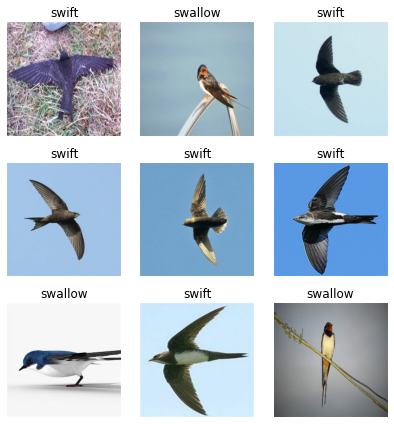

In [12]:
# Kiểm tra dữ liệu của 1 batch:
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    # Kiểm tra 9 ảnh:
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.uint8(images[i]))
        plt.title(class_names[np.int8(labels[i][1])])
        plt.axis('off')
        plt.tight_layout()

## Xây dựng model

> Chúng ta sẽ sử dụng một model đã được học trước, thay vì tạo 1 model từ đầu

In [53]:
from keras.applications.resnet50 import preprocess_input, ResNet50

Chúng ta sử dụng model đã được học sẵn là ResNet50, tuy nhiên sẽ không dùng layer cuối vì tác vụ khác so với bài toán của chúng ta.

In [65]:
# Tạo một base model, trong đó, lọc bỏ 2 layers cuối cùng (flatten và predict) của model đã được đào tạo rồi:
model = ResNet50(include_top=False, weights='imagenet', input_shape=[224, 224, 3])
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Sau đó, bổ sung thêm layer cho ứng dụng của chúng ta. Ở đây, chúng ta sẽ tạo lại layer flatten và layer prediction cuối cùng để dự báo kết quả.

In [66]:
flatten = keras.layers.Flatten()(model.output) # Kéo phẳng kết quả của model ResNet50
prediction = keras.layers.Dense(2, activation='sigmoid', name='prediction')(flatten)
base_model = keras.models.Model(inputs=model.inputs, outputs=prediction)
base_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [67]:
# Tổng kết model:
base_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
base_model.fit(train_ds, epochs=5, validation_data=valid_ds)

Epoch 1/5
4/4 [==============================] - 18s 1s/step - loss: 13.8102 - accuracy: 0.4774 - val_loss: 50343216.0000 - val_accuracy: 0.5349
Epoch 2/5
4/4 [==============================] - 2s 516ms/step - loss: 1.8663 - accuracy: 0.7373 - val_loss: 70571592.0000 - val_accuracy: 0.5349
Epoch 3/5
4/4 [==============================] - 2s 490ms/step - loss: 4.3366 - accuracy: 0.7244 - val_loss: 296414240.0000 - val_accuracy: 0.5116
Epoch 4/5
4/4 [==============================] - 2s 480ms/step - loss: 5.9106 - accuracy: 0.7932 - val_loss: 539123136.0000 - val_accuracy: 0.4651
Epoch 5/5
4/4 [==============================] - 2s 491ms/step - loss: 0.5067 - accuracy: 0.9241 - val_loss: 888026.6250 - val_accuracy: 0.5349


### Biến đổi dữ liệu
> Vừa rồi chúng ta mới chỉ quy chuẩn dữ liệu về size 224 cho tất cả các ảnh. Còn rất nhiều phương pháp biến đổi dữ liệu khác nhau mà chúng ta muốn sử dụng.

In [4]:
?image.ImageDataGenerator

Init signature:
image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, fe

In [39]:
?train_ds.apply

Signature: train_ds.apply(transformation_func)
Docstring:
Applies a transformation function to this dataset.

`apply` enables chaining of custom `Dataset` transformations, which are
represented as functions that take one `Dataset` argument and return a
transformed `Dataset`.

>>> dataset = tf.data.Dataset.range(100)
>>> def dataset_fn(ds):
...   return ds.filter(lambda x: x < 5)
>>> dataset = dataset.apply(dataset_fn)
>>> list(dataset.as_numpy_iterator())
[0, 1, 2, 3, 4]

Args:
  transformation_func: A function that takes one `Dataset` argument and
    returns a `Dataset`.

Returns:
  Dataset: The `Dataset` returned by applying `transformation_func` to this
      dataset.
File:      ~/miniconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py
Type:      method


In [48]:
def apply_brightness(image, label):
    image = keras.preprocessing.image.random_brightness(image, brightness_range=(.2, .75))
    return image, label

In [5]:
train_ds.apply(apply_brightness)

NameError: name 'train_ds' is not defined